<center>
NNTI Assignment 2

November 16, 2023

Name: Aleksey Morshnev
Student ID: 7042691
Email: almo00008@stud.uni-saarland.de
</center>

# Exercise 2.3 - Eigenfaces (3.5pts)

<figure>
<a id="examples"><center><img src="imgs/eigenfaces.png" style="width:50%"/></center></a>
<figcaption align = "center"> Figure 1: Some examples of eigenfaces. </figcaption>
</figure>

In this assignment you will compute [eigenfaces](http://engr.case.edu/merat_francis/eecs490f04/References/Face%20Recognition/LD%20Face%20analysis.pdf) of the [Olivetti faces dataset](https://scikit-learn.org/stable/datasets/real_world.html#the-olivetti-faces-dataset). Note that the linked ressources are only here to provide additional background knowledge and you do not need to understand them in any detail to complete this assignment. In general, eigenfaces can be seen as a compressed version of the individual faces in the dataset from which the original faces can be reconstructed. You can find some examples in [Figure 1](#examples). For general datasets, this approach of finding compressed features is also known as Principal Components Analysis (PCA), which will be covered in detail in upcoming lectures. To complete this assignment, however, the material covered up to Chapter 3 is sufficient. 

In [1]:
# List of packages you want to check/install
packages_to_install = ["numpy", "pandas", "matplotlib"]

In [2]:
%%time
import importlib

for package_name in packages_to_install:
    try:
        importlib.import_module(package_name)
        print(f"{package_name} is already installed.")
    except ImportError:
        print(f"{package_name} is not installed. Installing it now...")
        !conda install -y {package_name}

numpy is already installed.
pandas is already installed.
matplotlib is already installed.
CPU times: user 221 ms, sys: 0 ns, total: 221 ms
Wall time: 220 ms


In [3]:
import sys
assert sys.version_info >= (3, 6), "This notebook requires python version >= 3.6 to support type hints."

In [4]:
from typing import Tuple

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_faces(imgs: np.ndarray, n: int) -> None:
    """Plots the first n images from imgs
    args:
        imgs: a numpy array of shape (N, 64, 64) containing N 64x64 images
        n: number of images to plot
    """
    assert imgs.shape[0] >= n, f"imgs array must contain at least {n} images"
    assert imgs.ndim == 3, f"imgs array must be of shape (N, H, W)"
    assert imgs.shape[1:] == (64, 64), f"Images must be of dimension (64, 64) not {imgs.shape[1:]}. If you passed flattened images, reshape them first."

    # If n=1, create a single-subplot figure
    if n == 1:
        fig, ax = plt.subplots(1, 1)
        ax.imshow(imgs[0])
        ax.set_axis_off()
    else:
        # For n > 1, create a multi-subplot figure
        fig, axes = plt.subplots(1, n)
        for i in range(n):
            axes[i].imshow(imgs[i])
            axes[i].set_axis_off()

    plt.show()

The faces are stored as a numpy array and are loaded by executing the cell below. Make sure to place the file `faces.npy` that comes with the assignment in the same folder as this notebook.

In [6]:
faces = np.load('faces.npy')
faces.shape

(400, 64, 64)

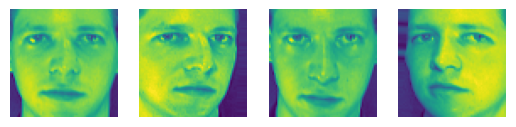

In [7]:
plot_faces(faces, 4)

## Exercise 2.3.1 - Preprocess (0.5pts)
First, calculate the average of all the face images in the dataset to find the mean face. Then, adjust each image in the dataset by subtracting this mean face from it, effectively centering the dataset. For reference, the mean face should look as in [Figure 2](#meanface). Lastly, flatten each image into a vector. After preprocessing, your dataset should contain 400 4096-dimensional vectors.

<figure>
<a id="examples"><center><img src="imgs/meanface.png" style="width:15%"/></center></a>
<figcaption align = "center"> Figure 2: Mean face. </figcaption>
</figure>

In [8]:
def preprocess(faces: np.ndarray) -> np.ndarray:
    """Subtracts the mean face, flattens each face image into a vector, and centers the dataset."""
    flattened_faces = faces.reshape((400, -1))  # shape (400, 64*64)
    
    # Step 2: Mean centering
    mean_face = np.mean(flattened_faces, axis=0)
    centered_faces = flattened_faces - mean_face
    return centered_faces

## Exercise 2.3.2 - EVD (1pt)
Compute the covariance matrix of the preprocessed faces using the formula $\text{Var}[\boldsymbol{X}] = \frac{1}{m - 1} \boldsymbol{X}^T \boldsymbol{X}$, where $\boldsymbol{X} \in \mathbb{R}^{m\times n}$. Afterwards, find its eigenvectors ordered in descending order by their corresponding eigenvalues. You can use `sort_eigvectors` to do the sorting. Afterwards, plot the first four eigenfaces.

**Note:** If you use numpy, you will need to use `np.linalg.eigh` instead of `np.linalg.eig` to compute the eigendecomposition to avoid running into numerical issues. 

In [9]:
def sort_eigvectors(eigvalues: np.ndarray, eigvectors: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Sorts eigenvectors according to their corresponding eigenvalues. The input is expected to be the result of np.linalg.eigh.""" 
    idx = np.argsort(eigvalues)[::-1]
    eigvalues = eigvalues[idx] 
    eigvectors = eigvectors[:, idx]
    
    return eigvalues, eigvectors

(4096, 4)


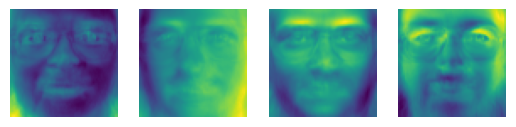

CPU times: user 46.8 s, sys: 439 ms, total: 47.2 s
Wall time: 7.17 s


In [10]:
%%time
def compute_covariance_matrix(X):
    m, n = X.shape
    if m <= 1:
        raise ValueError("Input matrix X must have more than one sample for covariance computation.")
    covariance_matrix = (1 / (m - 1)) * np.dot(X.T, X)
    return covariance_matrix

def eigenfaces_evd(face_vectors: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    covariance_matrix = compute_covariance_matrix(face_vectors)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_eigenvalues, sorted_eigenvectors = sort_eigvectors(eigenvalues, eigenvectors)
    return sorted_eigenvalues, sorted_eigenvectors

ei_values, ei_vectors = eigenfaces_evd(preprocess(faces))

k = 4
top_k_eigenvectors = ei_vectors[:, :k]
print(top_k_eigenvectors.shape)

plot_faces(top_k_eigenvectors.T.reshape((4, 64, 64)), 4)

## Exercise 2.3.3 - SVD (0.5pt)
Eigenfaces can also be computed using a singular value decomposition of the data matrix. Complete `eigenfaces_svd` by computing a singular value decomposition and returning the right singular values of the data matrix. Again, plot the first four eigenfaces.

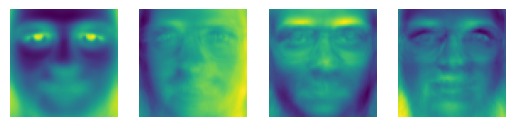

CPU times: user 2.48 s, sys: 30.1 ms, total: 2.51 s
Wall time: 401 ms


In [11]:
%%time
def eigenfaces_svd(face_vectors: np.ndarray) -> np.ndarray:
    _, _, Vt = np.linalg.svd(face_vectors, full_matrices=False)
    eigenfaces = Vt[:4, :]
    return eigenfaces

eigenfaces_svd_result = eigenfaces_svd(faces.reshape(400, 4096))
plot_faces(eigenfaces_svd_result.reshape((4, 64, 64)), 4)

**Note**: The brightness values for some images might be inverted compared to the examples in [Figure 1](#examples) or those computed using the EVD. This is due to different algorithms used under the hood and you don't need to worry about it.

## Exercise 2.3.4 - Reconstruction (1pt)
Reconstruct the faces in the dataset with varying levels of accuracy. Use the SVD for this and vary the accuracy by including more or fewer singular values. You can do this by setting more or fewer singular values inside the diagonal matrix $\boldsymbol{D}$ to zero. Plot the first four faces in the dataset once using 25 singular values  and once using 200 singular values.

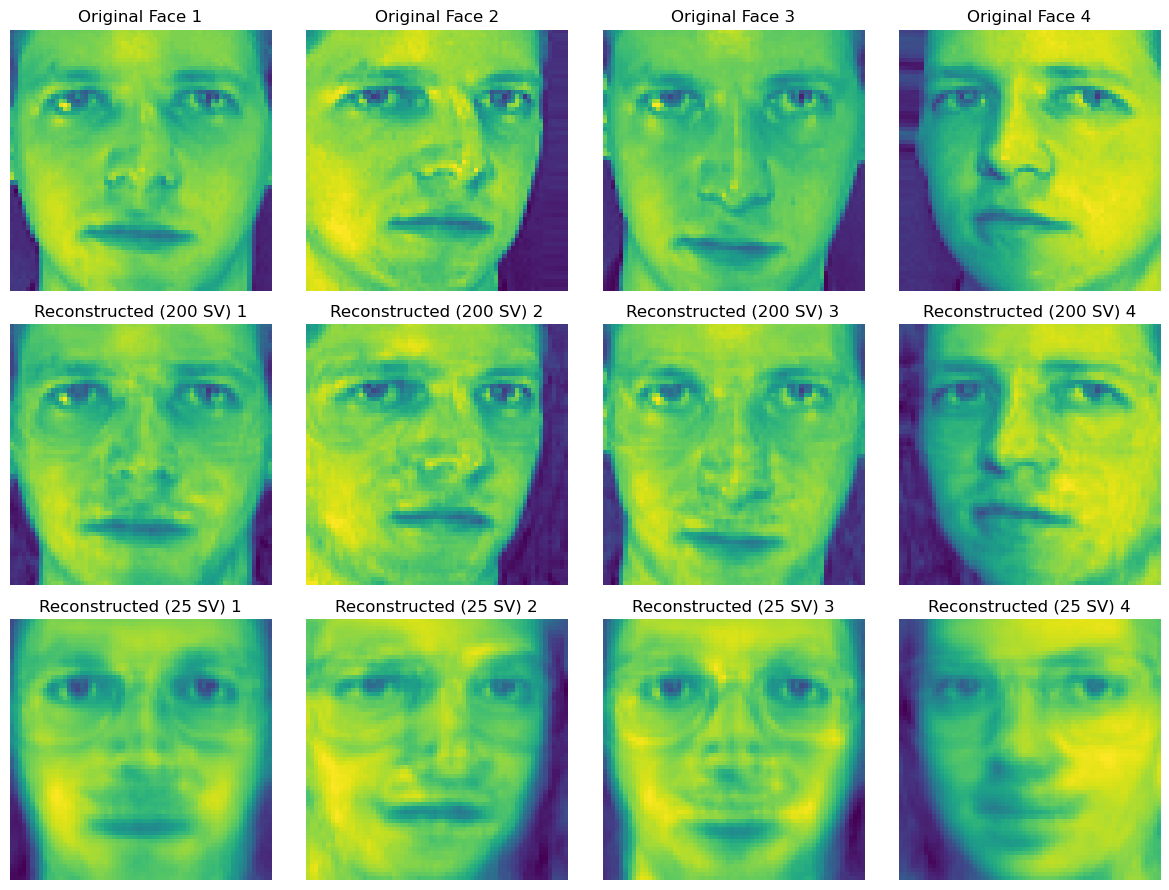

In [12]:
def reconstruct(faces: np.ndarray, num_singular_values: int) -> np.ndarray:
    U, S, Vt = np.linalg.svd(faces, full_matrices=False)
    S[num_singular_values:] = 0
    reconstructed_faces = U @ np.diag(S) @ Vt
    return reconstructed_faces

reconstructed_faces_25 = reconstruct(faces.reshape(400, 4096), num_singular_values=25)
reconstructed_faces_200 = reconstruct(faces.reshape(400, 4096), num_singular_values=200)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for i in range(4):
    axes[0, i].imshow(faces[i].reshape(64, 64))
    axes[0, i].set_title(f'Original Face {i + 1}')
    axes[0, i].axis('off')

for i in range(4):
    axes[1, i].imshow(reconstructed_faces_200[i].reshape(64, 64))
    axes[1, i].set_title(f'Reconstructed (200 SV) {i + 1}')
    axes[1, i].axis('off')

for i in range(4):
    axes[2, i].imshow(reconstructed_faces_25[i].reshape(64, 64))
    axes[2, i].set_title(f'Reconstructed (25 SV) {i + 1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

## Exercise 2.3.5 - Quiz (0.5pts)
1. Why are the results of exercise 2.3.2 and 2.3.3 the same?
2. (Optional) You may have noticed that the computation using the singular value decomposition was much faster than the eigenvalue decomposition.
   Why is this the case?

## Answers
1. Results of applying eigendecomposition and applying SVD are same because for a symmetric matrix (covariance matrix) the eigendecomposition is equivalent to the SVD.
2. True - eigendecomposition took 6.25s while SVD took 297ms. I believe the difference comes from the fact that eigendecomposition needs covariance matrix to be calculated, while SVD does not need that. Reason why I believe so is that, while debugging my own code, I found out that computing covariance matrix takes almost the same time as computing eigendecomposition. Hence I can assume most of its slowness comes from covariance matrix computation.